In [1]:
import sqlite3
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import (CSVLogger, EarlyStopping, History, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D

In [3]:
# Can this run on GPU
tf.config.list_physical_devices('GPU')

[]

In [2]:
# Constants
RANDOM_STATE = 32  # DO NOT CHANGE, images will have to be resorted
SQL_DATABASE = "data/galaxy_data.sqlite"
TRAIN_IMAGES_ARRAY_NPY = "data/training_images_array.npy"

TRAIN_IMAGES_DIR = "data/train_images/"
TEST_IMAGES_DIR = "data/test_images/"

# Initialize variable for model
model = None

## Import the data and split for testing and training

In [3]:
# load from SQLite database
connection = sqlite3.connect(SQL_DATABASE)
df_import = pd.read_sql("SELECT * from galaxy_data", connection)
connection.close()

# Make sure there are no null values in data
df_import.isnull().any(axis=1).sum()

0

In [4]:
# keep only needed values
stratify_data = df_import["class_reduced"].values
x_image_id_names = df_import["asset_id"]

y_output_data = df_import.drop(["objid", "sample", "asset_id", "dr7objid", "ra", "dec", "gz2_class", "class_reduced"], axis=1)
y_output_data.shape

(239267, 37)

`RANDOM_STATE` needs to be the same as the value in `data_image_cleaning.ipynb`

In [5]:
# Split data into testing and training
# X is asset names, not the actual images
X_train_assets, X_test_assets, y_train, y_test = train_test_split(x_image_id_names,
                                                                  y_output_data,
                                                                  random_state=RANDOM_STATE,
                                                                  stratify=stratify_data)
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [6]:
def load_png_images_from_directory(directory: str,  image_list: list[int]) -> np.array:
    """
    Load grayscale PNG images from a directory into a numpy array.

    Images must be integer names in `image_list`, order is important
    
    :param directory: path to directory
    :param image_list: array of integers representing file names
    :return: array of image arrays
    """
    images = []
    for img_name in image_list:
        img_array = cv2.imread(f"{directory}{img_name}.png", cv2.IMREAD_GRAYSCALE).astype("float32") / 255.0
        images.append(img_array)
    X_image_array = np.array(images)
    return X_image_array

In [23]:
# Load or Save and Load .npy file for training images
if Path(TRAIN_IMAGES_ARRAY_NPY).exists():
    # Image npy file exists, load it
    X_train_images = np.load(TRAIN_IMAGES_ARRAY_NPY, "r")
else:
    # npy file does not exist, load individual images and save npy file
    print("Creating `training_images_array.npy` file...")
    X_train_images = load_png_images_from_directory(TRAIN_IMAGES_DIR, X_train_assets)
    np.save(TRAIN_IMAGES_ARRAY_NPY, X_train_images)
print("Images loaded into `X_train_images`")

Creating `training_images_array.npy` file...
Images loaded into `X_train_images`


In [9]:
# Load Training images (uncomment below to load each image into array from a directory)
# X_train_images = load_png_images_from_directory(TRAIN_IMAGES_DIR, X_train_assets)
# X_train_images = load_png_images_from_directory(TEST_IMAGES_DIR, X_test_assets)
print("X_train_images Shape:", X_train_images.shape)
print("X_train_images Size", X_train_images.nbytes, "bytes")
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

X_train_images Shape: (59817, 106, 106)
X_train_images Size 2688415248 bytes
y_train Shape: (179450, 37)
y_test Shape: (59817, 37)


## Create the Model
This model is a regression model even though is appears to be classifying galaxies. That is because it is really measuring the confidence levels of the group of people classifying the galaxies.

In [31]:
# Callbacks for Early Stopping and Checkpoints
# - https://www.tensorflow.org/tutorials/keras/save_and_load
checkpoints = ModelCheckpoint("data/model/checkpoints/cp-{epoch:03d}.ckpt",
                              monitor="loss", mode="min",
                              save_weights_only=True,
                              verbose=0)
early_stopping = EarlyStopping(monitor="loss", patience=7)

# Callbacks for Reducing Learning Rate
def scheduler(epoch: int, lr: float) -> float:
    """Slightly reduce the learning rate every 10 epochs"""
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.8
    else: # No change
        return lr
    
lr_scheduler = LearningRateScheduler(scheduler, verbose=0)
reduce_lr_plateau = ReduceLROnPlateau(monitor="loss",
                                      factor=0.1, min_lr=0.000_000_01,
                                      patience=5,
                                      verbose=0)

# Logging (history from .fit() is only saved for the current run of the model)
# CSVLogger can add new data to existing file to persist information
csv_logger_start = CSVLogger("data/model/training_log.csv", separator=",", append=False)
csv_logger_resume = CSVLogger("data/model/training_log.csv", separator=",", append=True)

callbacks_ = [checkpoints, early_stopping, lr_scheduler, reduce_lr_plateau, csv_logger_start]
callbacks_resume = [checkpoints, early_stopping, lr_scheduler, reduce_lr_plateau, csv_logger_resume]

In [11]:
# Visualize Loss and Metric over the epochs
history_plt_style = {'axes.edgecolor':'white',
             'axes.facecolor': '#333',
             'axes.labelcolor': 'white',
             'axes.titlecolor': 'white',
             'axes.grid': True,
             'grid.color': '#222',
             'legend.labelcolor': 'white',
             'legend.loc': 'best',
             'xtick.color':'white',
             'ytick.color':'white'}

def plot_history(fit_history: History, metric: str, metric_full_name: str):
    """Creates a plot for history of the followed metric and Loss (MSE)"""
    with plt.rc_context(history_plt_style):
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        fig.patch.set_facecolor('#222')
        # tracked Metric Graph
        axs[0].plot(fit_history.history[metric], label=f'train_{metric}')
        axs[0].plot(fit_history.history[f'val_{metric}'], label=f'val_{metric}')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel(metric_full_name)
        axs[0].legend()
        # Loss Graph
        axs[1].plot(fit_history.history['loss'], label='train_loss')
        axs[1].plot(fit_history.history['val_loss'], label='val_loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss (Mean Squared Error)')
        axs[1].legend()
        plt.show()

In [8]:
def r2_score(y_true, y_pred):
    """Custom R Squared metric as R2Score() in tensorflow 2.13.0
    causes type error and is not available in earlier versions"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

In [33]:
IMG_SIZE = X_train_images[0].shape[0]
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

# Create a sequential model
model = Sequential()

# Add convolution layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2, seed=RANDOM_STATE))
# Flatten the output from convolution layers
model.add(Flatten())

# Add dense (fully connected) layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, seed=RANDOM_STATE))

model.add(Dense(64, activation='relu'))

# Add the output layer with 37 units (for 37 classes)
model.add(Dense(37, activation='sigmoid'))

# Compile the model
# Since values are like confidence levels from the classifiers, this is really a regression, not a classification
# metric names: "root_mean_squared_error" and "r2_score"
model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), r2_score])  # mse=mean_squared_error

# Print the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 104, 104, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 52, 52, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 25, 25, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 23, 23, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 11, 11, 128)      

In [ ]:
# Create weight function/array/list to give weight to rare categories
class_weights = {
    0: 1,   # t01_smooth
    1: 1,   # t01_features
    2: 1,   # t01_star_artifact
    3: 1,   # t02_edge_on_yes
    4: 1,   # t02_edge_on_no
    5: 1,   # t03_bar_yes
    6: 1,   # t03_bar_no
    7: 1,   # t04_spiral_yes
    8: 1,   # t04_spiral_no
    9: 1,   # t05_bulge_prominence_no_bulge
    10: 1,  # t05_bulge_prominence_just
    11: 1,  # t05_bulge_prominence_obvious
    12: 1,  # t05_bulge_prominence_dominant
    13: 1,  # t06_odd_yes
    14: 1,  # t06_odd_no
    15: 1,  # t07_rounded_completely_round
    16: 1,  # t07_rounded_in_between
    17: 1,  # t07_rounded_cigar_shaped
    18: 1,  # t08_odd_feature_ring
    19: 1,  # t08_odd_feature_lens_or_arc
    20: 1,  # t08_odd_feature_disturbed
    21: 1,  # t08_odd_feature_irregular
    22: 1,  # t08_odd_feature_other
    23: 1,  # t08_odd_feature_merger
    24: 1,  # t08_odd_feature_dust_lane
    25: 1,  # t09_bulge_shape_rounded
    26: 1,  # t09_bulge_shape_boxy
    27: 1,  # t09_bulge_shape_no_bulge
    28: 1,  # t10_arms_winding_tight
    29: 1,  # t10_arms_winding_medium
    30: 1,  # t10_arms_winding_loose
    31: 1,  # t11_arms_number_1
    32: 1,  # t11_arms_number_2
    33: 1,  # t11_arms_number_3
    34: 1,  # t11_arms_number_4
    35: 1,  # t11_arms_number_more_than_4
    36: 1,  # t11_arms_number_cant_tell
}

### Train the Model

In [ ]:
history = model.fit(X_train_images,
                    y_train,
                    epochs=2,
                    callbacks=callbacks_,
                    batch_size=2_000,
                    validation_split=0.1)

# Plots
plot_history(history, "r2_score", "R² Score")
# plot_history(history, "root_mean_squared_error", "RMSE")

In [ ]:
model.save("data/model/GalaxyConfidenceModel.keras")
print("Saved Model!")

---
## Continue Training if Needed
Set `initial_epoch` and increase `epochs` to new final value

In [ ]:
if model is None:
    model = load_model("data/model/GalaxyConfidenceModel.keras", custom_objects={'r2_score': r2_score})
    print("Model loaded!")

Epoch 16/35
27/27 [==============================] - 157s 4s/step - loss: 0.0658 - root_mean_squared_error: 0.2566 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2514 - lr: 8.0000e-04
Epoch 17/35
27/27 [==============================] - 122s 5s/step - loss: 0.0653 - root_mean_squared_error: 0.2556 - val_loss: 0.0629 - val_root_mean_squared_error: 0.2509 - lr: 8.0000e-04
Epoch 18/35
27/27 [==============================] - 114s 4s/step - loss: 0.0648 - root_mean_squared_error: 0.2546 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2500 - lr: 8.0000e-04
Epoch 19/35
27/27 [==============================] - 136s 5s/step - loss: 0.0639 - root_mean_squared_error: 0.2527 - val_loss: 0.0615 - val_root_mean_squared_error: 0.2479 - lr: 8.0000e-04
Epoch 20/35
27/27 [==============================] - 159s 6s/step - loss: 0.0634 - root_mean_squared_error: 0.2518 - val_loss: 0.0611 - val_root_mean_squared_error: 0.2472 - lr: 8.0000e-04
Epoch 21/35
27/27 [==============================] - 15

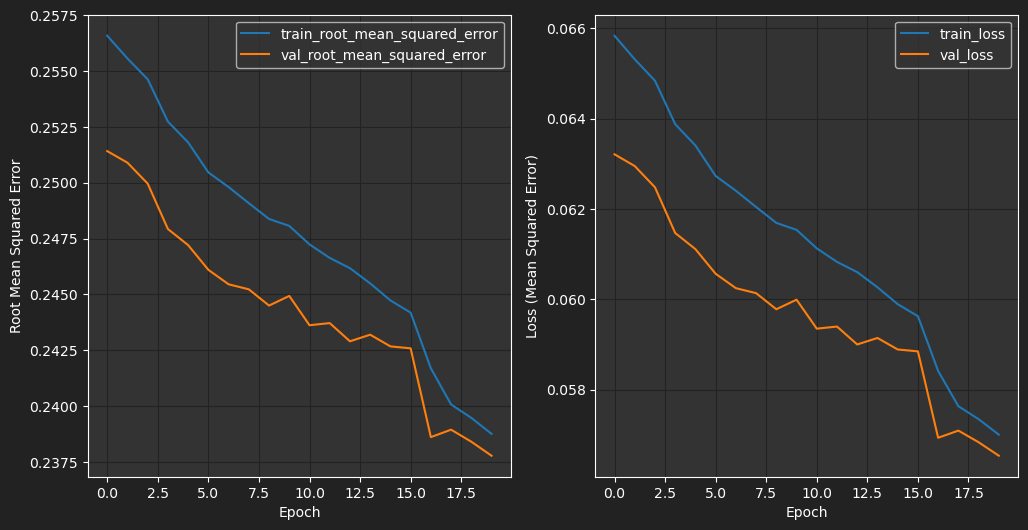

In [19]:
# Continue training model
history = model.fit(X_train_images,
                    y_train,
                    initial_epoch=15,    # TODO Set ending epoch from previous training
                    epochs=35,          # Total Epochs (new + previous)
                    callbacks=callbacks_resume,  # want to append to existing CSV log
                    batch_size=2_000,
                    validation_split=0.1)

# Plots (only from `initial_epoch` to end)
plot_history(history, "r2_score", "R² Score")

In [21]:
model.save("data/model/GalaxyConfidenceModel.keras")
print("Saved Updated Model!")

Saved!


---
## Show Full Training History
If the training was done in multiple pieces or using `model_training.py`, this cell can be used to create the graphs for all the epochs from the saved `training_log.csv` file created during training found in `data\model\`.


(50, 8)


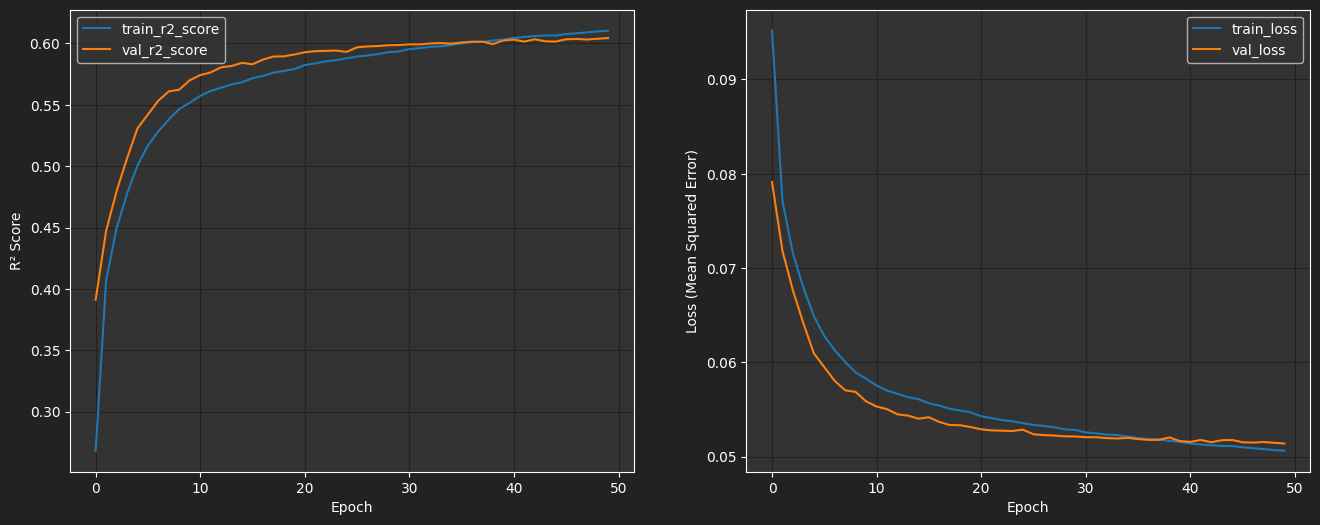

In [12]:
def plot_history_full(history: pd.DataFrame, metric: str, metric_full_name: str):
    """Creates a plot for history of the followed metric and Loss (MSE)"""
    with plt.rc_context(history_plt_style):
        fig, axs = plt.subplots(1, 2, figsize=(16,6))
        fig.patch.set_facecolor('#222')
        # tracked Metric Graph
        axs[0].plot(history[metric], label=f'train_{metric}')
        axs[0].plot(history[f'val_{metric}'], label=f'val_{metric}')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel(metric_full_name)
        axs[0].legend()
        # Loss Graph
        axs[1].plot(history['loss'], label='train_loss')
        axs[1].plot(history['val_loss'], label='val_loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss (Mean Squared Error)')
        axs[1].legend()
        plt.show()

df_history = pd.read_csv("data/model/training_log.csv")
print(df_history.shape)
plot_history_full(df_history, "r2_score", "R² Score")
# plot_history_full(df_history, "root_mean_squared_error", "Root Mean Squared Error")

---

## Test the model

In [14]:
# Load model for testing if not already loaded
if model is None:
    model = load_model("data/model/GalaxyConfidenceModel.keras", custom_objects={'r2_score': r2_score})
    print("Model loaded for testing!")

Model loaded for testing!


In [15]:
X_test_images = load_png_images_from_directory(TEST_IMAGES_DIR, X_test_assets)
print("X_test_images Shape:", X_test_images.shape)
print("X_test_images Size", X_test_images.nbytes, "bytes")
print("y_test Shape:", y_test.shape)

X_test_images Shape: (59817, 106, 106)
X_test_images Size 2688415248 bytes
y_test Shape: (59817, 37)


In [17]:
# Evaluate the model using the test data
model_loss, model_rmse, model_r2 = model.evaluate(X_test_images, y_test, verbose=2)
print(f"Loss: {model_loss}, RMSE: {model_rmse}, R2: {model_r2}")

1870/1870 - 46s - loss: 0.0513 - root_mean_squared_error: 0.2265 - r2_score: 0.6049 - 46s/epoch - 25ms/step
Loss: 0.05130842700600624, RMSE: 0.22651353478431702, R2: 0.6049375534057617


---
## Make Predictions
Be able to take in any image and convert it for use with the model. Then make the predictions and return a series with 37 entries.

In [34]:
if model is None:
    model = load_model("data/model/GalaxyConfidenceModel.keras", custom_objects={'r2_score': r2_score})
    print("Model loaded for predictions!")

def prepare_image(image_path: str, square_size: int=106) -> np.array:
    """Prepares any sized image for use with this model

    :param image_path: file path to image
    :param square_size: Output length, defaults to 106
    :return: image array
    """
    # Load image as gray scale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if(image.shape[0] > image.shape[1]):
        r = square_size / float(image.shape[0])
        dim = (int(image.shape[1] * r), square_size)
    else:
        r = square_size / float(image.shape[1])
        dim = (square_size, int(image.shape[0] * r))

    # Resize the image
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_CUBIC)
    resized = np.expand_dims(resized, axis=2)  # change array from (106, 106) to (106, 106, 1) to match prepared_image

    # Create a new image with almost black (7) pixels as the background is never perfectly black
    prepared_image = np.full((square_size, square_size, 1), 7, np.uint8)  # shape = (106, 106, 1)

    # Get the center coordinates of the background image to place the resized image
    x_offset = (square_size - resized.shape[1]) // 2
    y_offset = (square_size - resized.shape[0]) // 2

    # Place the resized image on the black image
    prepared_image[y_offset:y_offset+resized.shape[0], x_offset:x_offset+resized.shape[1]] = resized

    # final changes to float array for model
    predict_img = prepared_image.astype("float32") / 255.0

    return predict_img

def predict_image(file_path: str) -> pd.Series:
    """Returns a series containing the predictions for a given image

    :param image_array: file path to image
    :return: Series of predictions
    """
    image_array = prepare_image(file_path)
    image_array = np.expand_dims(image_array, axis=0)  # prediction needs another dimension at start for (1, 106, 106, 1)
    predictions = model.predict(image_array)
    readable_predict = pd.Series(predictions[0], y_output_data.columns.values)
    return readable_predict

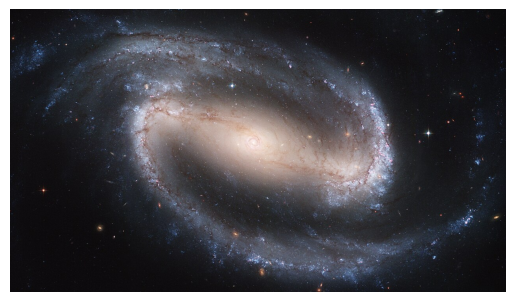

1/1 [==============================] - 0s 17ms/step


t01_smooth_or_features_a01_smooth_debiased              0.082562
t01_smooth_or_features_a02_features_or_disk_debiased    0.893209
t01_smooth_or_features_a03_star_or_artifact_debiased    0.019317
t02_edgeon_a04_yes_debiased                             0.084533
t02_edgeon_a05_no_debiased                              0.882224
t03_bar_a06_bar_debiased                                0.415915
t03_bar_a07_no_bar_debiased                             0.507807
t04_spiral_a08_spiral_debiased                          0.834501
t04_spiral_a09_no_spiral_debiased                       0.143043
t05_bulge_prominence_a10_no_bulge_debiased              0.014196
t05_bulge_prominence_a11_just_noticeable_debiased       0.547891
t05_bulge_prominence_a12_obvious_debiased               0.455364
t05_bulge_prominence_a13_dominant_debiased              0.058939
t06_odd_a14_yes_debiased                                0.607789
t06_odd_a15_no_debiased                                 0.380654
t07_rounded_a16_completel

In [39]:
# Test prediction with real image. This is a face on Barred Spiral Galaxy with 2 arms. It has very distinct features
test_image_path = r"images\Ex_SBb_NGC1300-HST.jpg"
plt.imshow(plt.imread(test_image_path))
plt.axis('off')
plt.show()
result = predict_image(test_image_path)
result